## Import Libraries

In [1]:
# Data and preprocessing
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Deep Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Saving/loading tools
import pickle

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\nanin\anaconda3\envs\emotion_chatbot\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Load Dataset

In [2]:
# Load dataset
data = pd.read_csv(r"C:\Users\nanin\Downloads\Chatbot\data\emotion_final.csv")

# Basic info
print("Dataset shape:", data.shape)
data.head()


Dataset shape: (21459, 2)


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Dataset Exploration

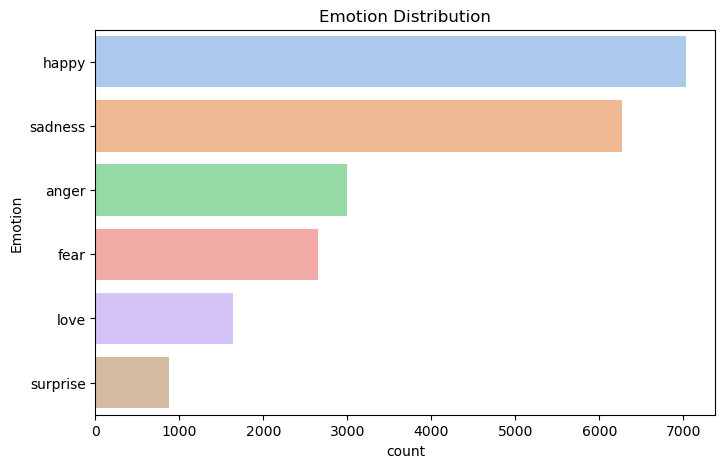

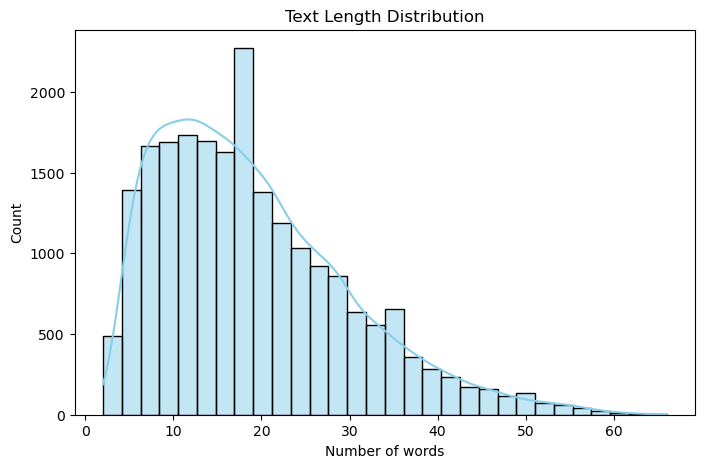

In [3]:

# Emotion distribution
plt.figure(figsize=(8,5))
sns.countplot(data['Emotion'], palette="pastel", order=data['Emotion'].value_counts().index)
plt.title("Emotion Distribution")
plt.show()

# Text length distribution
data['text_len'] = data['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(data['text_len'], bins=30, kde=True, color='skyblue')
plt.title("Text Length Distribution")
plt.xlabel("Number of words")
plt.show()

## Text Cleaning

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.strip()

data['Text'] = data['Text'].apply(clean_text)
data.head()


,Text,Emotion,text_len
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,21
2,im grabbing a minute to post i feel greedy wrong,anger,10
3,i am ever feeling nostalgic about the fireplac...,love,18
4,i am feeling grouchy,anger,4


## Word Clouds per Emotion

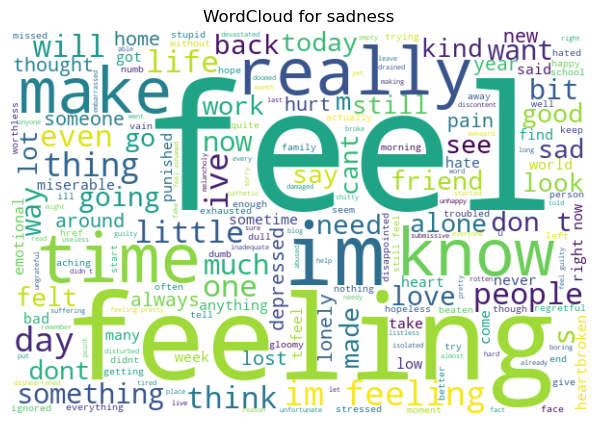

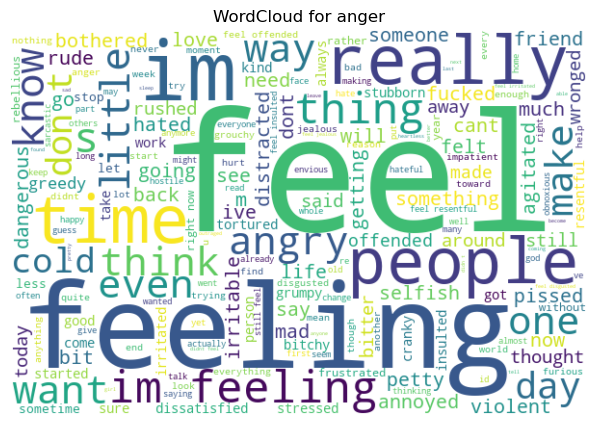

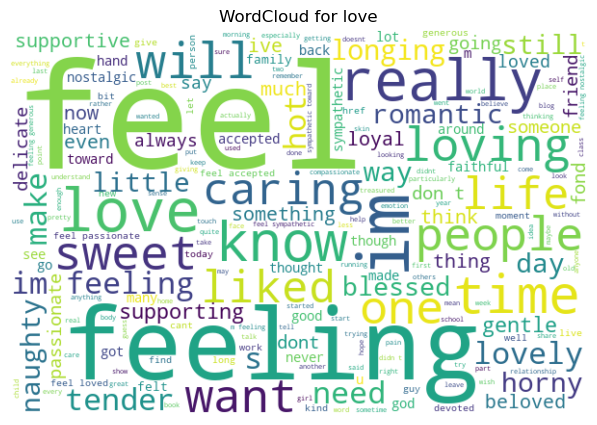

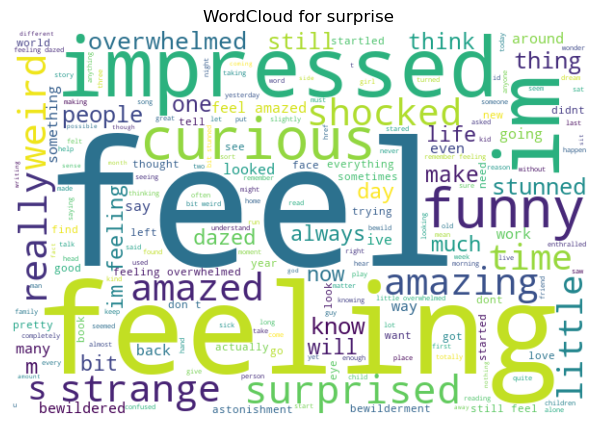

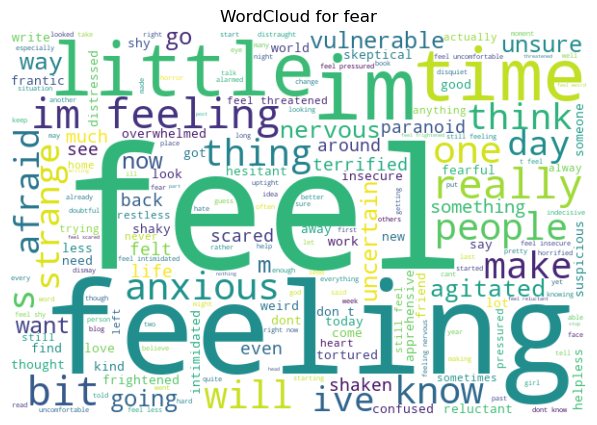

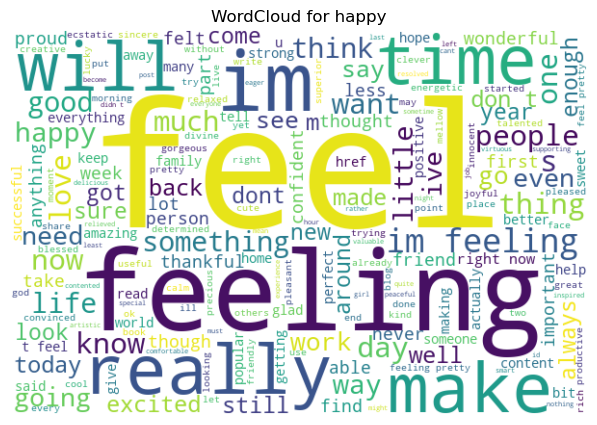

In [5]:
for emotion in data['Emotion'].unique():
    text = " ".join(data[data['Emotion']==emotion]['Text'])
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {emotion}")
    plt.show()


## Encode labels

In [6]:
# Encode emotion labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['Emotion'])
labels_onehot = to_categorical(labels)

print("Classes:", label_encoder.classes_)


Classes: ['anger' 'fear' 'happy' 'love' 'sadness' 'surprise']


## Tokenize the text

In [7]:
# Tokenization for deep learning
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data["Text"])
sequences = tokenizer.texts_to_sequences(data["Text"])
max_len = 100
X = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")


print("Shape of X:", X.shape)


Shape of X: (21459, 100)


## Train Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, labels_onehot, test_size=0.2, random_state=42, stratify=labels
)


## Model Building 

In [9]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 56s 118ms/step - accuracy: 0.5649 - loss: 1.1374 - val_accuracy: 0.8157 - val_loss: 0.5650
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 49s 115ms/step - accuracy: 0.9037 - loss: 0.2947 - val_accuracy: 0.9033 - val_loss: 0.2714
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 54s 126ms/step - accuracy: 0.9445 - loss: 0.1620 - val_accuracy: 0.8751 - val_loss: 0.3782
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 52s 120ms/step - accuracy: 0.9611 - loss: 0.1152 - val_accuracy: 0.8955 - val_loss: 0.3019
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 52s 120ms/step - accuracy: 0.9693 - loss: 0.0859 - val_accuracy: 0.9016 - val_loss: 0.3248
Epoch 6/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 52s 122ms/step - accuracy: 0.9761 - loss: 0.0697 - val_accuracy: 0.8966 - val_loss: 0.3188
Epoch 7/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 53s 124ms/step - accuracy: 0.9782 - loss: 0.0615 - val_accuracy: 0.8963 - val_loss: 0.3891
Epoch 8/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 55s 129ms/step - accuracy: 0.9806 - loss: 0

In [11]:
import os 
chatbot_root = r"C:\Users\nanin\Downloads\Chatbot"
save_path = os.path.join(chatbot_root, "saved")
os.makedirs(save_path, exist_ok=True)

model.save(os.path.join(save_path, "chatbot_dl.h5"))

with open(os.path.join(save_path, "tokenizer.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)

with open(os.path.join(save_path, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

np.save(os.path.join(save_path, "X_test.npy"), X_test)
np.save(os.path.join(save_path, "y_test.npy"), y_test)

print(f"All files saved in: {save_path}")

All files saved in: C:\Users\nanin\Downloads\Chatbot\saved


## Training curves

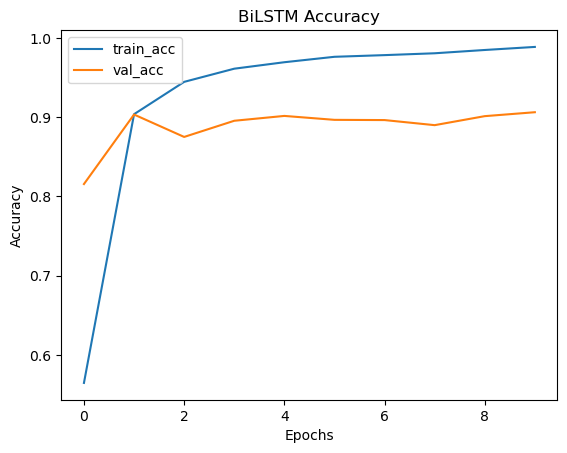

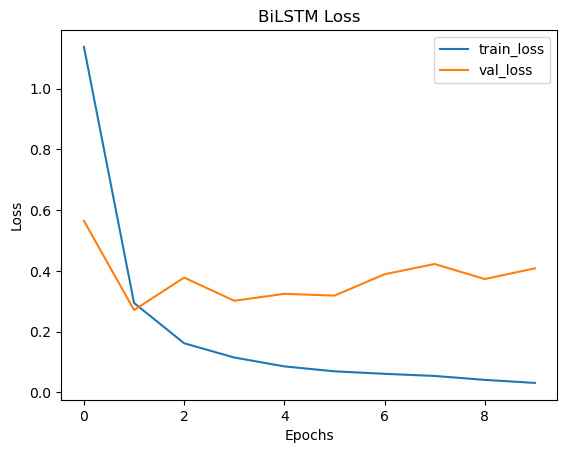

In [12]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("BiLSTM Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("BiLSTM Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Model Evaluation

135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step
Accuracy: 0.9005125815470643
              precision    recall  f1-score   support

       anger       0.85      0.92      0.88       599
        fear       0.91      0.84      0.87       530
       happy       0.92      0.93      0.93      1406
        love       0.78      0.84      0.81       328
     sadness       0.95      0.92      0.94      1253
    surprise       0.77      0.78      0.77       176

    accuracy                           0.90      4292
   macro avg       0.86      0.87      0.87      4292
weighted avg       0.90      0.90      0.90      4292



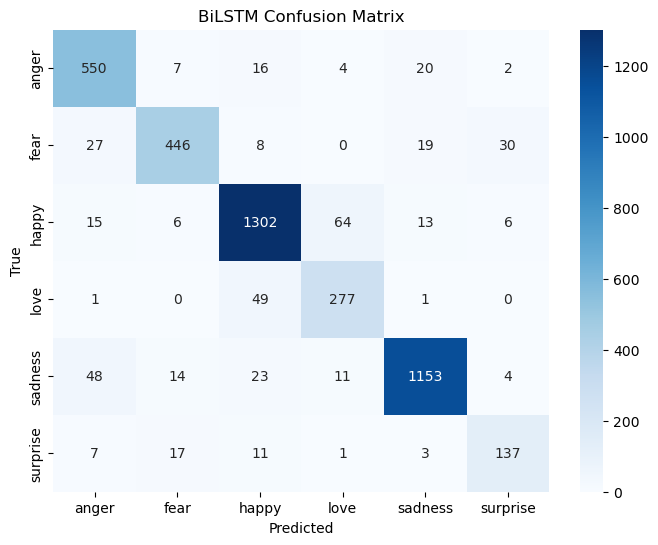

In [13]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BiLSTM Confusion Matrix")
plt.show()


## Baseline Traditional ML Models

In [15]:
# TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(data['Text'])
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42, stratify=labels)

# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_ml, y_train_ml)
y_pred_lr = lr.predict(X_test_ml)
print("Logistic Regression Accuracy:", accuracy_score(y_test_ml, y_pred_lr))

# SVM
svm = SVC()
svm.fit(X_train_ml, y_train_ml)
y_pred_svm = svm.predict(X_test_ml)
print("SVM Accuracy:", accuracy_score(y_test_ml, y_pred_svm))

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_ml, y_train_ml)
y_pred_rf = rf.predict(X_test_ml)
print("Random Forest Accuracy:", accuracy_score(y_test_ml, y_pred_rf))


Logistic Regression Accuracy: 0.8564771668219944
SVM Accuracy: 0.853215284249767
Random Forest Accuracy: 0.853448275862069


In [14]:
import re
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.strip()

def preprocess_input(text, tokenizer, max_len=100):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")
    return padded

def detect_negation(user_input):
    """
    Detect negations and flip emotion if needed.
    """
    text = clean_text(user_input)
    
    negations = ["not", "isnt", "isn't", "didnt", "didn't", "never", "cannot", "cant", "can't"]
    
    negation_map = {
        "happy": "sadness",
        "sadness": "happy",
        "anger": "neutral",
        "fear": "neutral",
        "surprise": "neutral",
        "disgust": "neutral"
    }
    
    words = text.split()
    neg_pos = [i for i, w in enumerate(words) if w in negations]
    
    emo_pos = []
    for i, w in enumerate(words):
        for emo in negation_map:
            if emo in w:
                emo_pos.append((i, emo))
    
    for n in neg_pos:
        for e_idx, emo in emo_pos:
            if e_idx > n:
                return negation_map[emo]
    
    return None


In [15]:
# Greetings & farewells
greetings = ["hi", "hello", "hey", "hiya"]
farewells = ["bye", "okay", "done", "thank you", "thanks"]

while True:
    user_input = input("You: ").strip()
    if user_input.lower() == "quit":
        print("Bot: Goodbye! Take care. 👋")
        break

    words = user_input.lower().split()

    if any(word in greetings for word in words):
        print("Bot: Hello! How are you feeling today?\n")
        continue

    if any(word in farewells for word in words):
        print("Bot: Goodbye! Take care. 👋\n")
        break

    label = detect_negation(user_input)

    if label is None:
        x = preprocess_input(user_input, tokenizer)
        prediction = model.predict(x)[0]
        max_prob = np.max(prediction)
        label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
        if max_prob < 0.5:
            print("Bot: Hmm, I’m not sure how you feel 🤔\n")
            continue

    print(f"Bot: I sense you are feeling **{label}**.\n")


You:  hi


Bot: Hello! How are you feeling today?



You:  i am hesitated


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Bot: Hmm, I’m not sure how you feel 🤔



You:  i am angry


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Bot: I sense you are feeling **anger**.



You:  i am happy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Bot: I sense you are feeling **happy**.



You:  i didnt feel humiliated


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Bot: I sense you are feeling **sadness**.



You:  i am feeling grouchy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Bot: I sense you are feeling **anger**.



You:  i think it s the easiest time of year to feel dissatisfied


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Bot: I sense you are feeling **anger**.



You:  i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my hear...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Bot: I sense you are feeling **fear**.



You:  bye


Bot: Goodbye! Take care. 👋

